# Krypton Corrections

## Correct energy using Kr maps and obtain resolution

### Author: JJGC

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Fri Aug 24 17:30:47 2018


### Input files

In [2]:
input_file_names  = ['dst_6284_trigger1_0000_7920.h5','dst_6285_trigger1_0000_7774.h5',
                    'dst_6286_trigger1_0000_7901.h5','dst_6287_trigger1_0000_7918.h5',
                    'dst_6288_trigger1_0000_7913.h5','dst_6289_trigger1_0000_8004.h5',
                    'dst_6290_trigger1_0000_4582.h5','dst_6291_trigger1_0000_4582.h5']



In [3]:
from krcal.core.kr_types import KrFileName

input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6284_trigger1_0000_7920.h5','dst_6285_trigger1_0000_7774.h5',
                    'dst_6286_trigger1_0000_7901.h5','dst_6287_trigger1_0000_7918.h5']
                    

output_file_name  = 'ldst_6284_6291.h5'
map_file_name     = 'kr_maps_6284_6291.h5'
map_file_name_ts  = 'kr_maps_ts_6284_6291.h5'
emap_file_name    = 'kr_emap_6284_6287.h5'

bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"

krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [5]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_energy_map
from krcal.core.io_functions       import read_energy_map

In [8]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg

In [9]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import events_sector
from krcal.core.analysis_functions      import event_map
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.analysis_functions      import kr_event

In [10]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [11]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import energy_map
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [12]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [13]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core          import fit_functions_ic as fitf

In [14]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_map2
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps
from krcal.core.map_functions   import draw_energy_map


In [15]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [16]:
from krcal.core.correction_functions import e0_correction
from krcal.core.correction_functions import lt_correction

In [17]:
import krcal.dev.corrections       as corrections 


In [18]:
from numpy import pi

In [19]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [20]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [21]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6284_trigger1_0000_7920.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6285_trigger1_0000_7774.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6286_trigger1_0000_7901.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6287_trigger1_0000_7918.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6284_6291.h5', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_6284_6291.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_ts_6284_6291.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_6284_6287.h5')

In [22]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [23]:
#unique_events = ~dst.event.duplicated()
#number_of_evts_full = np.count_nonzero(unique_events)

# Above does not work when glueing multiple DSTs, events ARE duplicated,
# since event number starts at 0, rather than taking true event number. 

print(f"Total number of events: {len(dst)}")

Total number of events: 6319827


In [24]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Select in R

In [25]:
RMAX       =180
NSECTORS   =10   # number of radial sectors, thus sector size RMAX/NSECTORS
SPHI       =15  # size of the wedge in degrees
NW = 360 / SPHI

fr = RMAX / NSECTORS
fphi = SPHI
print(f'fr = {fr}, fphi = {fphi}')


fr = 18.0, fphi = 15


In [26]:
dstf = dst[dst.R<RMAX]

In [27]:
dst = dstf

### Time differences in seconds

In [28]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [29]:
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-220,  220)
z_range   = (10,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

### Raw S2 energy vs Z

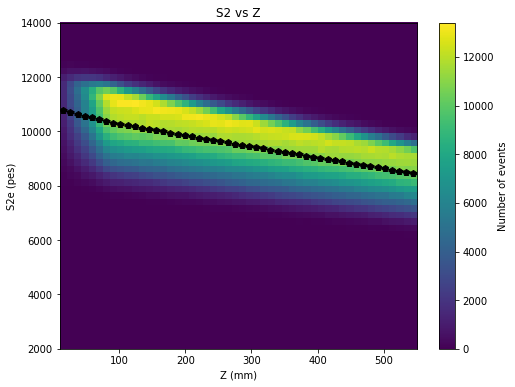

In [30]:
nevt = h2d(dst.Z, dst.S2e, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(8,6))

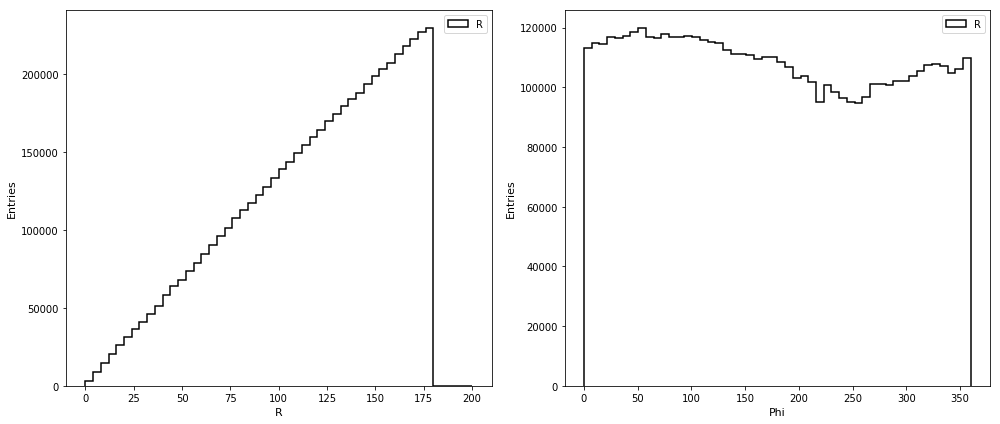

In [31]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
(_)    = h1(dst.R, bins=50, range = (0,200), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('R','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
(_)    = h1(phirad_to_deg(dst.Phi), bins=50, range = (0,360), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('Phi','Entries',''), ax)
plt.tight_layout()

### Plot "quantified" R and Phi

In [32]:
R = (dst.R.values / fr).astype(int)
Phi = (phirad_to_deg(dst.Phi.values) / fphi).astype(int)

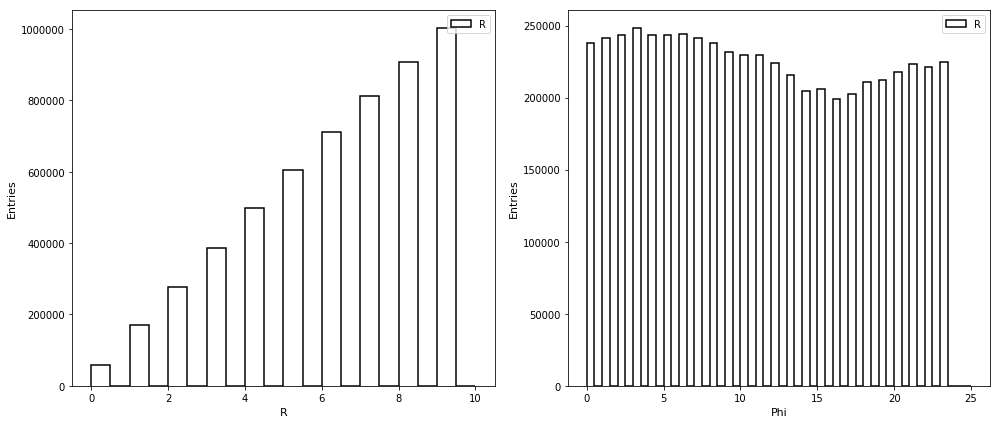

In [33]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
(_)    = h1(R, bins=20, range = (0,10), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('R','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
(_)    = h1(Phi, bins=50, range = (0,25), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('Phi','Entries',''), ax)
plt.tight_layout()

### Load maps

In [34]:
me0df, me0udf, mltdf, mltudf = read_maps(fn.map_file_name)
mu = (me0df.mean()).mean()
mx = (me0df.max()).max()

### E0 (geometry) correction

In [35]:
t0 = time.time()
E0 = e0_correction(dst.S2e.values, 
                  dst.R.values, 
                  dst.Phi.values, 
                  CE = me0df / mx,  # normalize to max E0
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 45.27227520942688


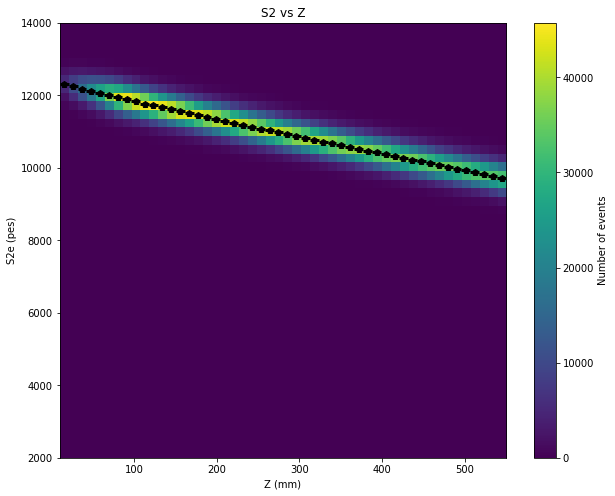

In [36]:
nevt = h2d(dst.Z, E0, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [37]:
t0 = time.time()
E = lt_correction(E0, 
                  dst.R.values, 
                  dst.Phi.values,
                  dst.Z.values, 
                  CLT = mltdf,
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 45.74524998664856


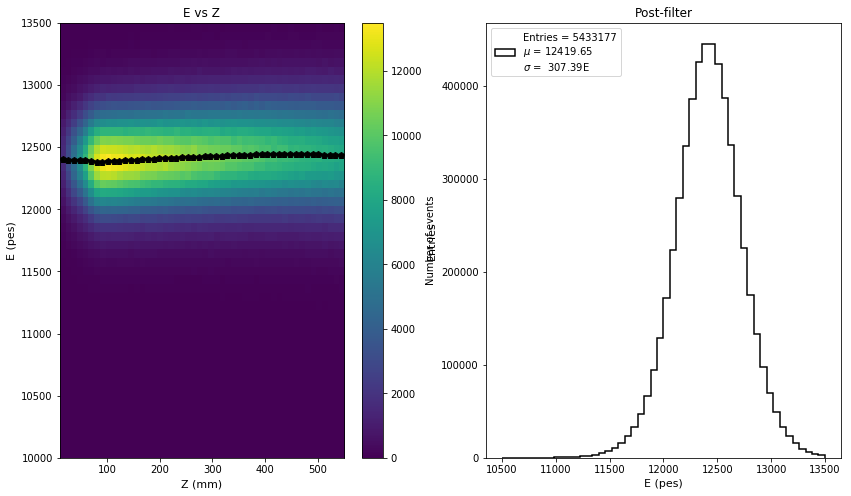

In [38]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, (10000, 13500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 50, range =(10500,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

In [39]:
fc = fit_energy(E, nbins=50, range=(11000, 13500))

  Fit was valid = True
 Emu       = 12422.055873121744 +-0.1307402504162809 
 E sigma   = 300.1341398171441 +-0.1016447896588222 
 chi2    = 20.174254958368174 
 sigma E/E (FWHM)     (%) =5.677926711764486
 sigma E/E (FWHM) Qbb (%) =0.7333153428026682 


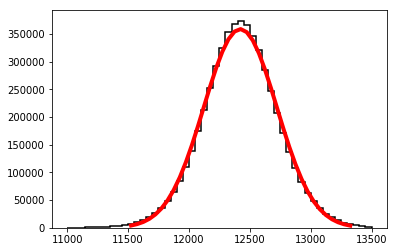

In [40]:
plot_fit_energy(fc)
print_fit_energy(fc)

In [41]:
kge = kr_event(dst, DT, E, E)

### Time dependence before/after correction

#### Before

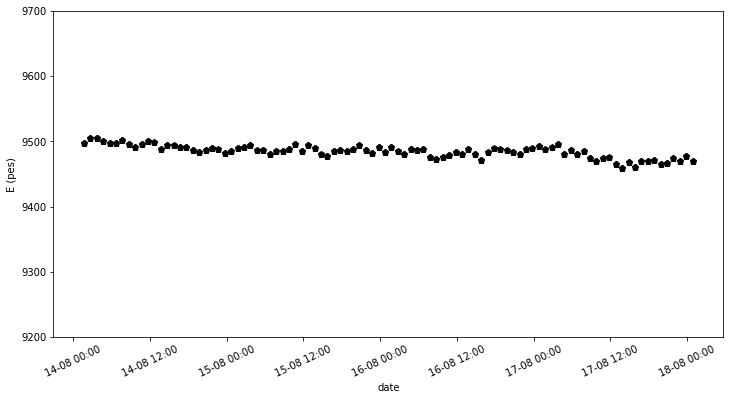

In [42]:
energy_time_profile(kge.T, kge.S2e, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(9200, 9700),  
                    figsize=(12,6))

#### After

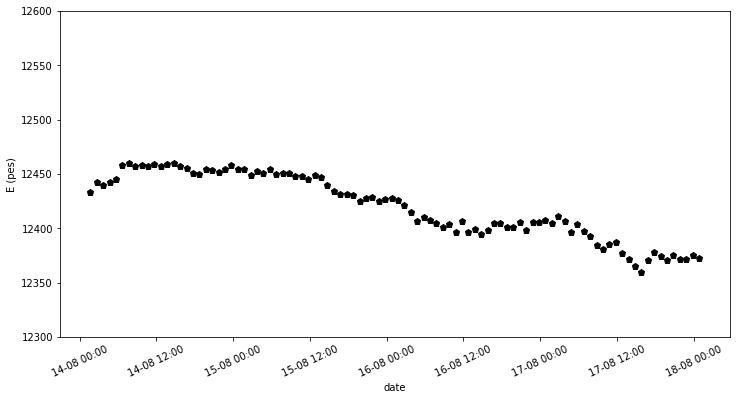

In [43]:
energy_time_profile(kge.T, kge.E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(12300, 12600),  
                    figsize=(12,6))

### Radial dependence

#### Before

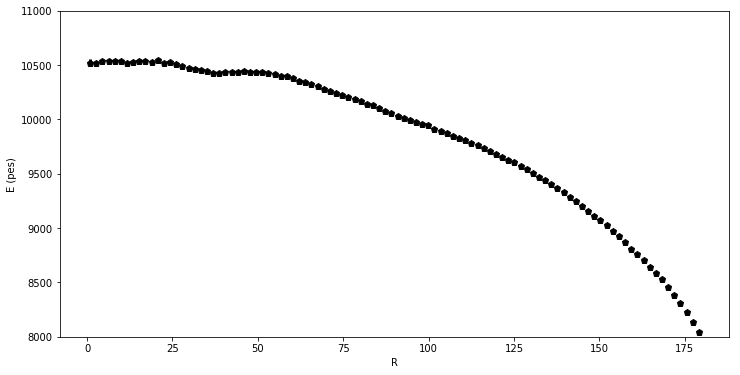

In [44]:
energy_X_profile(kge.R, kge.S2e, xnbins = 100, xrange=(0,180), xlabel = 'R',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After: Further corrections needed!

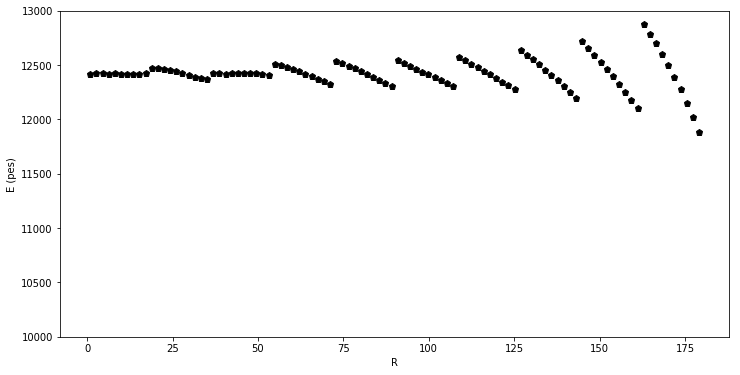

In [45]:
energy_X_profile(kge.R, kge.E, xnbins = 100, xrange=(0,180), xlabel = 'R',
                 erange=(10000, 13000),  
                 figsize=(12,6))

### Phi distribution

#### Before

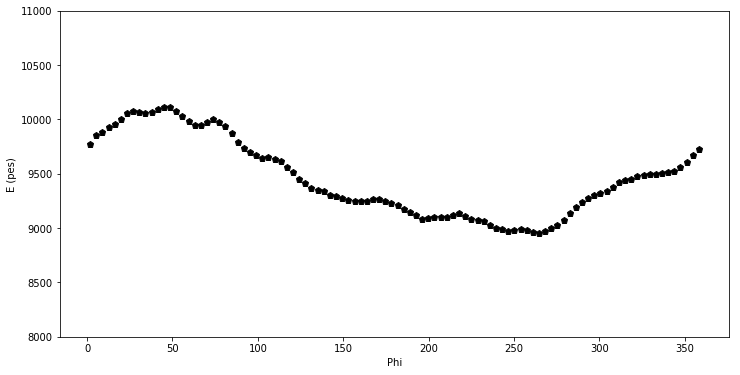

In [46]:
energy_X_profile(phirad_to_deg(kge.Phi), kge.S2e, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After! Further correction needed.

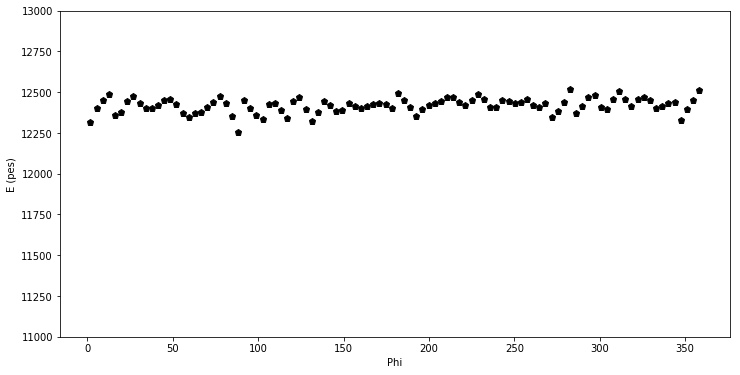

In [47]:
energy_X_profile(phirad_to_deg(kge.Phi), kge.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13000),  
                 figsize=(12,6))

### Dependence with Z

#### Before: shows the effect of lifetime

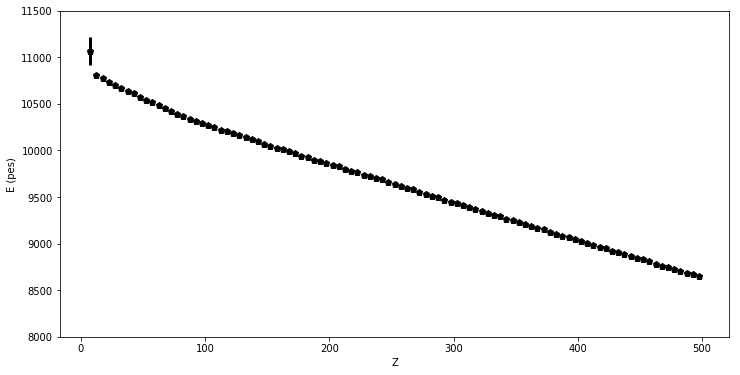

In [48]:
energy_X_profile(kge.Z, kge.S2e, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(8000, 11500),  
                 figsize=(12,6))

#### After: Lifetime corrected

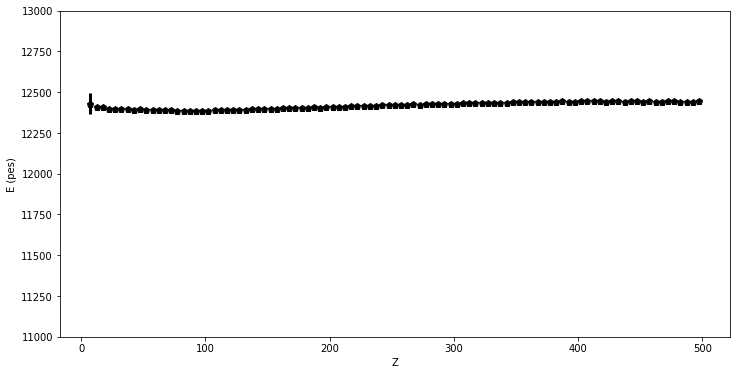

In [49]:
energy_X_profile(kge.Z, kge.E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13000),   
                 figsize=(12,6))

## Further geometrical correction is needed. This is done defining a fine-grained map for energy

In [50]:
R, PHI = rphi_sector_map(nSectors=50, rmax=180, sphi=3)
#print(f'sectors on R   = {R}')
#print(f'sectors on PHI = {PHI}')

In [51]:
W = define_rphi_sectors(R, PHI, verbose=False)

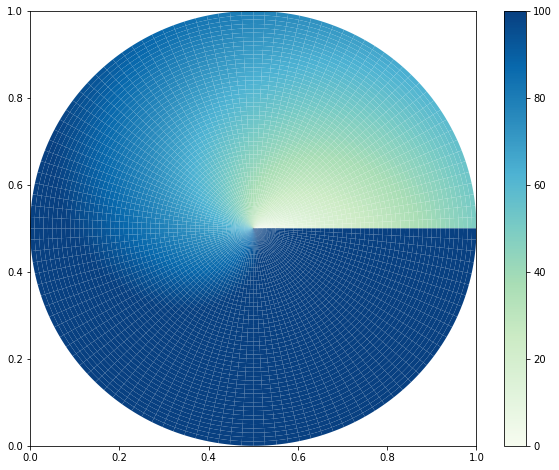

In [52]:
draw_wedges(W, cmap = matplotlib.cm.GnBu, rmax = 180, 
            scale= 0.5, figsize=(10,8), alpha=1.0,
            cr =range(50))

In [53]:
t0 = time.time()
KRES = select_rphi_sectors(dst, DT, E, E, W, verbose = True)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 calling selection_mask
 sector = 0
 sector = 1
 sector = 2
 sector = 3
 sector = 4
 sector = 5
 sector = 6
 sector = 7
 sector = 8
 sector = 9
 sector = 10
 sector = 11
 sector = 12
 sector = 13
 sector = 14
 sector = 15
 sector = 16
 sector = 17
 sector = 18
 sector = 19
 sector = 20
 sector = 21
 sector = 22
 sector = 23
 sector = 24
 sector = 25
 sector = 26
 sector = 27
 sector = 28
 sector = 29
 sector = 30
 sector = 31
 sector = 32
 sector = 33
 sector = 34
 sector = 35
 sector = 36
 sector = 37
 sector = 38
 sector = 39
 sector = 40
 sector = 41
 sector = 42
 sector = 43
 sector = 44
 sector = 45
 sector = 46
 sector = 47
 sector = 48
 sector = 49
 selection_mask computed, filling RGES
 defining kr_event for sector 0
 defining kr_event for sector 1
 defining kr_event for sector 2
 defining kr_event for sector 3
 defining kr_event for sector 4
 defining kr_event for sector 5
 defining kr_event for sector 6
 defining kr_event for sector 7
 defining kr_event for sector 8
 defining

In [54]:
nMap = event_map(KRES)

In [55]:
nS = events_sector(nMap)

In [56]:
nS

array([  19.45      ,   59.96666667,   97.275     ,  137.90833333,
        173.45833333,  213.6       ,  248.43333333,  284.43333333,
        312.89166667,  349.23333333,  381.61666667,  427.4       ,
        469.66666667,  499.65833333,  532.11666667,  570.275     ,
        603.91666667,  644.76666667,  681.90833333,  723.88333333,
        757.675     ,  797.03333333,  835.13333333,  869.86666667,
        901.5       ,  938.23333333,  974.        , 1008.8       ,
       1050.65833333, 1079.96666667, 1120.34166667, 1152.23333333,
       1185.8       , 1224.55      , 1254.35      , 1285.41666667,
       1323.95833333, 1353.85      , 1388.675     , 1411.23333333,
       1450.49166667, 1482.79166667, 1513.59166667, 1543.925     ,
       1578.66666667, 1611.65833333, 1646.075     , 1677.45      ,
       1702.66666667, 1724.025     ])

In [57]:
eM = energy_map(KRES)

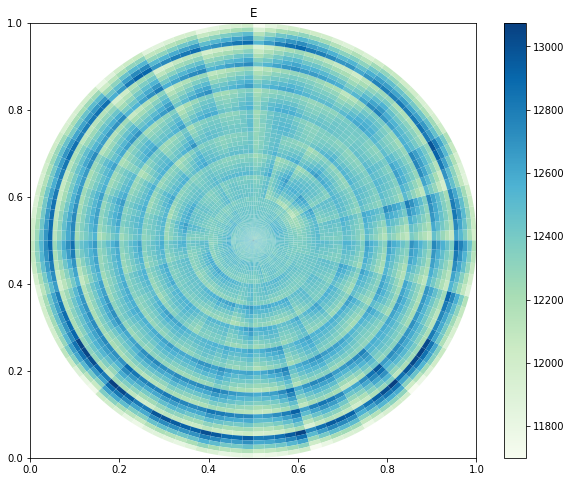

In [58]:
draw_energy_map(W, eM, 
                elims  = None,
                cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
                alpha   = 1.0,  
                figsize=(10,8))

In [60]:
write_energy_map(eM, filename=fn.emap_file_name)


In [61]:
eMap = read_energy_map(filename=fn.emap_file_name)

In [62]:
eMap

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,12440.829293,12419.351260,12418.628854,12424.994192,12401.210861,12493.590796,12464.418649,12420.891631,12397.244270,12372.954493,...,12472.681774,12386.499023,12272.836273,12164.678911,12077.120644,12627.662231,12516.604429,12374.004200,12203.363693,11987.783619
1,12451.278942,12374.009153,12378.894621,12386.361364,12420.978793,12488.686812,12455.475023,12442.077696,12405.123123,12378.486726,...,12596.281423,12499.295195,12411.047307,12308.179553,12191.308479,12748.837517,12613.144918,12461.635197,12279.875405,12055.900924
2,12362.057592,12461.795148,12394.705781,12405.700361,12412.971768,12492.107315,12492.824851,12428.026402,12404.218655,12363.872016,...,12676.657771,12574.532347,12464.220970,12368.572691,12254.551169,12830.552048,12693.904428,12510.930182,12304.609890,12074.448707
3,12431.706180,12451.713599,12423.765642,12435.459031,12432.655513,12495.942666,12485.125307,12441.931727,12375.454881,12366.175597,...,12701.169228,12597.405102,12491.316790,12358.204521,12260.493408,12805.430053,12658.864326,12478.532271,12277.206891,12039.898869
4,12430.151482,12408.151511,12417.852795,12428.206123,12443.851515,12523.529832,12478.912140,12424.136975,12399.044148,12340.332139,...,12737.885741,12618.477655,12501.087144,12354.088861,12231.162024,12761.840053,12605.588431,12424.013710,12232.679820,12007.753888
5,12378.448061,12394.537810,12364.021786,12432.132124,12423.360066,12529.289657,12526.504135,12472.036641,12378.686405,12345.970590,...,12495.806316,12382.224086,12281.893112,12118.101811,11985.218909,12625.009488,12471.407300,12288.313451,12093.610278,11876.425931
6,12388.387521,12362.112518,12397.374285,12423.526269,12433.952569,12516.466736,12514.813207,12469.404547,12361.411352,12281.446965,...,12618.302824,12506.800893,12367.694099,12219.846784,12053.688024,12703.163559,12512.000683,12317.475867,12111.444902,11894.253923
7,12505.651325,12380.282117,12416.898090,12432.165931,12452.843026,12549.833228,12527.991617,12456.577164,12362.809000,12283.845091,...,12721.558042,12610.363850,12458.246190,12322.152428,12166.487694,12817.215359,12630.710226,12407.412995,12195.508556,11958.680227
8,12333.725833,12415.449835,12404.373333,12397.618423,12468.867438,12520.735869,12506.305698,12437.433917,12348.054542,12257.486070,...,12756.521738,12644.158276,12515.643419,12392.421712,12248.365647,12916.368508,12729.470785,12527.211912,12324.474260,12075.449564
9,12393.035365,12413.472984,12412.867641,12397.558908,12480.553547,12553.305921,12515.453488,12436.220169,12343.987411,12257.052427,...,12748.291968,12648.591448,12535.683869,12424.372154,12291.140707,12982.823708,12804.891529,12612.396104,12405.755263,12167.436385


In [63]:
mu = (eMap.mean()).mean()
mu

12425.460277940314

In [64]:
ns = 50 # number of radial sectors used to compute map
nw = 120 # number of phi sectors used to compute map

fr = RMAX / ns
fphi = 360 / nw
print(f'fr = {fr}, fphi = {fphi}')

fr = 3.6, fphi = 3.0


In [65]:
t0 = time.time()
Ec = e0_correction(E, 
                  dst.R.values, 
                  dst.Phi.values, 
                  CE = eMap / mu,  # normalize to mean
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 44.500255823135376


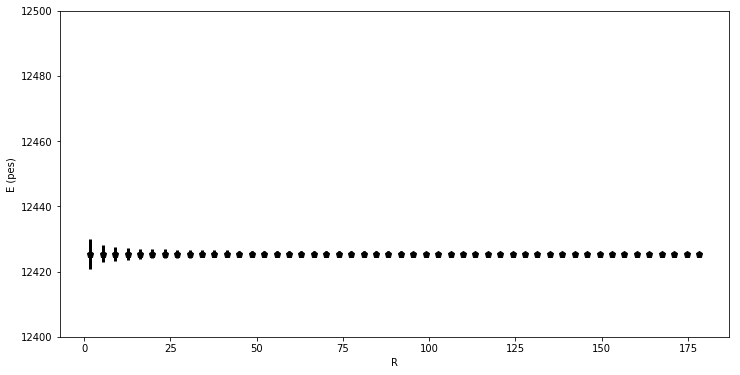

In [68]:
energy_X_profile(kge.R, Ec, xnbins = 50, xrange=(0,180), xlabel = 'R',
                 erange=(12400, 12500),  
                 figsize=(12,6))

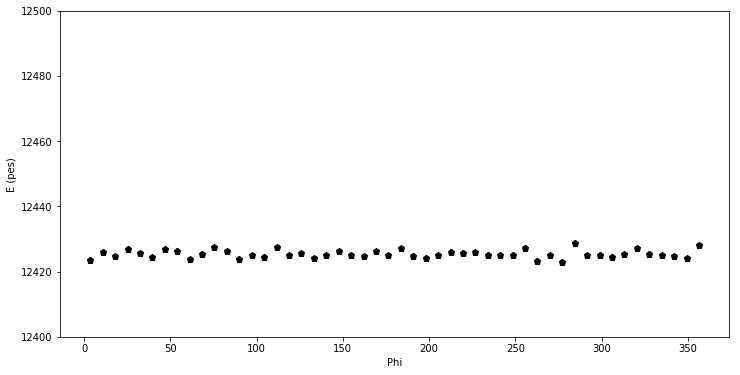

In [71]:
energy_X_profile(phirad_to_deg(kge.Phi), Ec, xnbins = 50, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(12400, 12500),  
                 figsize=(12,6))

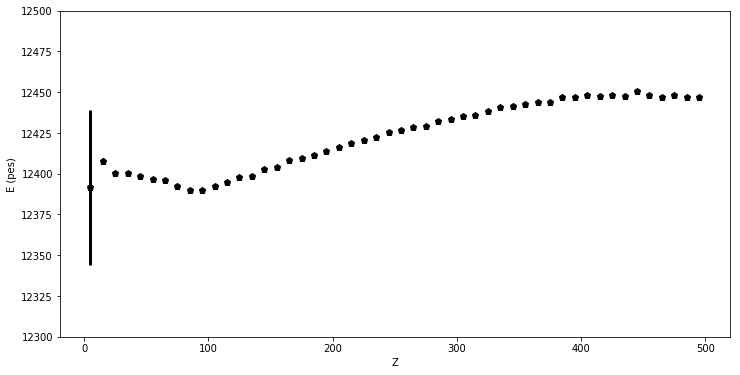

In [73]:
energy_X_profile(kge.Z, Ec, xnbins = 50, xrange=(0,500), xlabel = 'Z',
                 erange=(12300, 12500),   
                 figsize=(12,6))

### R and Phi distributions fixed, Z showing residual effects

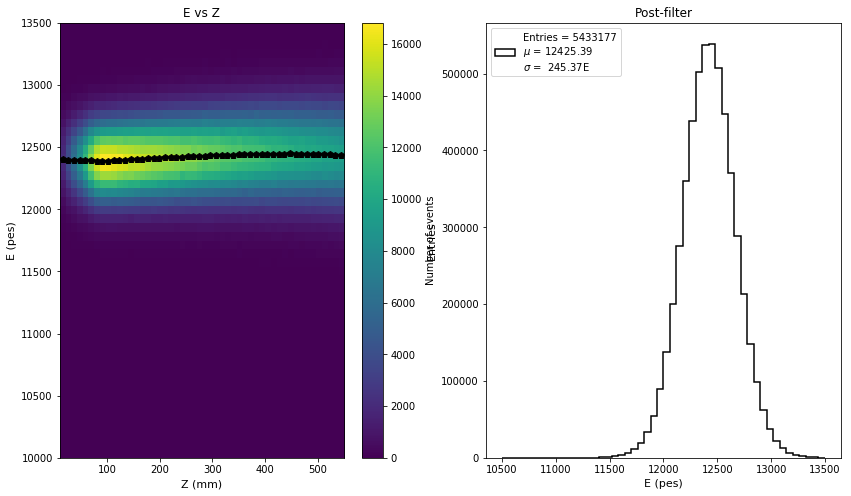

In [74]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, Ec, krNbins.Z, krNbins.S2e, krRanges.Z, (10000, 13500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ec,  bins = 50, range =(10500,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12424.986261700327 +-0.10853726343600743 
 E sigma   = 241.1260540326416 +-0.08731233042515976 
 chi2    = 5.832137376595755 
 sigma E/E (FWHM)     (%) =4.560538056475595
 sigma E/E (FWHM) Qbb (%) =0.5890024119754319 


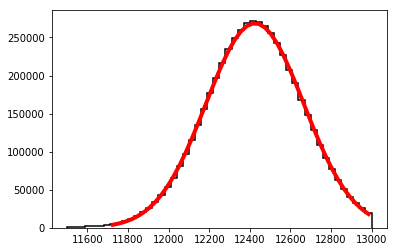

In [75]:
fc = fit_energy(Ec, nbins=50, range=(11500, 13000))
plot_fit_energy(fc)
print_fit_energy(fc)

### Time correction

(12300, 12500)

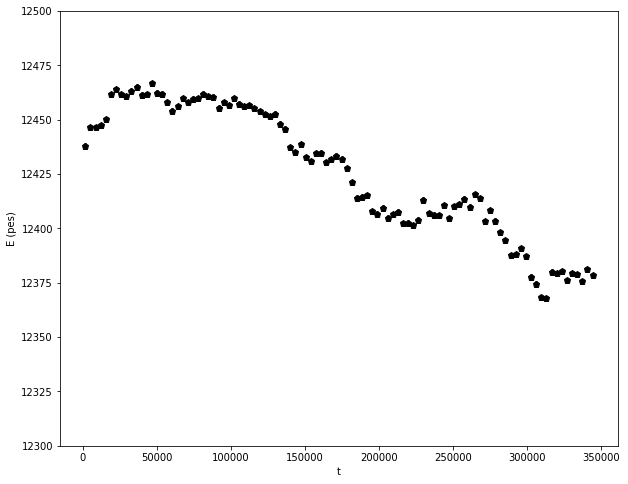

In [78]:
T   =(kge.T - kge.T.min()) 
t, e, eu = fitf.profileX(T, Ec, 100)
erange =(12300, 12500)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E (pes)')
plt.ylim(erange)

In [79]:
e_mu    = np.nanmean(Ec)
print(e_mu)
e_std   = np.nanstd (Ec)
print(e_std)

12425.460277940301
245.52035227124463


In [80]:
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ek  = Ec * ET_correction(T).value

(12300, 12500)

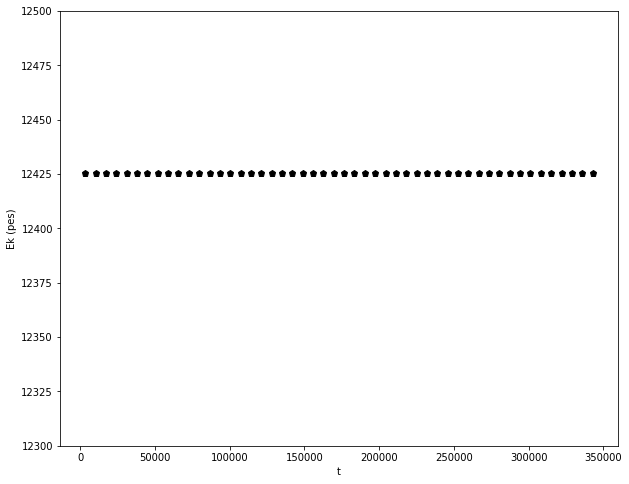

In [81]:
tc, ec, euc = fitf.profileX(T, Ek, 50)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('Ek (pes)')
plt.ylim(erange)

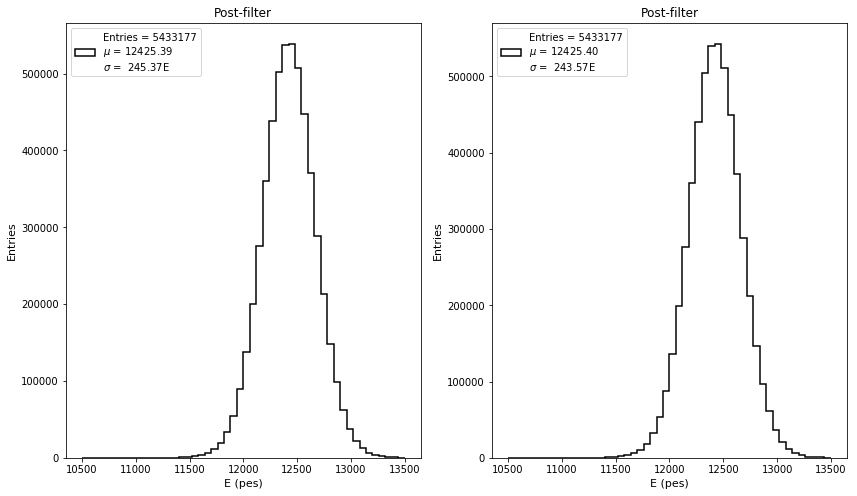

In [82]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

(_)     = h1(Ec,  bins = 50, range =(10500,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ek,  bins = 50, range =(10500,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12425.118522030874 +-0.10759503020845461 
 E sigma   = 239.50666098807264 +-0.08625783348172975 
 chi2    = 5.58849302643209 
 sigma E/E (FWHM)     (%) =4.529861444170553
 sigma E/E (FWHM) Qbb (%) =0.5850404674822269 


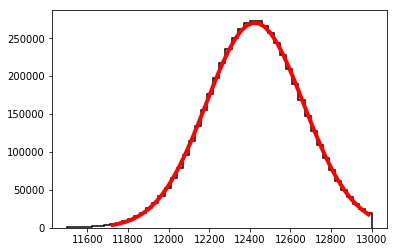

In [83]:
fc = fit_energy(Ek, nbins=50, range=(11500, 13000))
plot_fit_energy(fc)
print_fit_energy(fc)

### As a function of R and Z

In [84]:
Ri = (50,100,150,180)
Zi = range(50,600,50)

FWHM = resolution_r_z(Ri, Zi, kge.R, kge.Z, Ek)

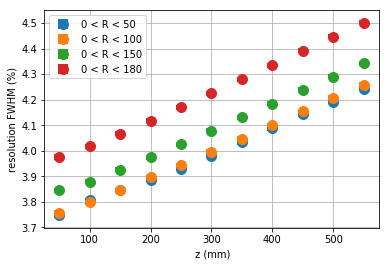

In [85]:
plot_resolution_r_z(Ri, Zi, FWHM)


### Is it possible to reduce the dependence in Z with time-dependent fits?